# MLP Classifier on Iris Dataset
**Name: Mohammed Jaheeruddin Shaik**

**Student ID : 23102347**

This notebook gives a thorough and organized analysis of Multilayer Perceptrons (MLP) using the Iris dataset.  Beyond basic training, we investigate architecture tuning, solver and activation comparisons, cross-validation, noise robustness, overfitting/underfitting behaviors, junk feature stress tests, and model reliability analysis to demonstrate the topic's complexities and neural network principles.


In [163]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [164]:
df = pd.read_csv('iris_dataset.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [165]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   target_name        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


## Pairplot Visualization

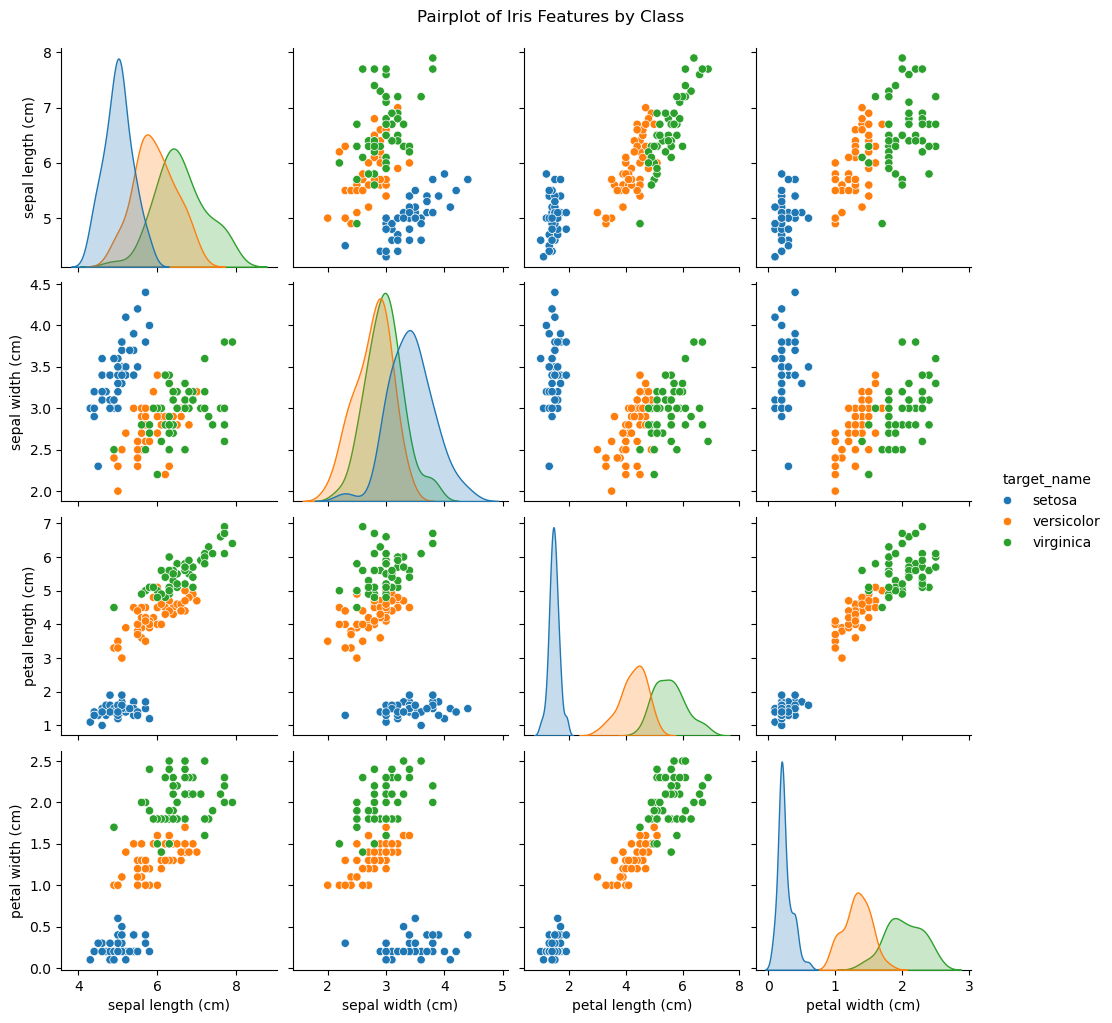

In [168]:
def plot_feature_distributions(data):
    sns.pairplot(data.drop(columns=['target']), hue='target_name')
    plt.suptitle('Pairplot of Iris Features by Class', y=1.02)
    plt.show()

plot_feature_distributions(df)

## Train-Test Split

In [170]:
def split_data(df):
    X = df.iloc[:, :4].values
    y = df['target'].values
    target_names = df['target_name'].unique()
    return train_test_split(X, y, test_size=0.2, random_state=42), target_names

(X_train, X_test, y_train, y_test), target_names = split_data(df)

## Architecture, Activation, and Solver Comparison

In [172]:
def compare_mlp_configurations(X, y):
    """
    Evaluate different MLPClassifier configurations using cross-validation.
    Returns a DataFrame with accuracy for each configuration.
    """
    configs = [
        {'hidden_layer_sizes': (10), 'activation': 'relu', 'solver': 'adam'},
        {'hidden_layer_sizes': (10), 'activation': 'logistic', 'solver': 'adam'},
        {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'adam'},
        {'hidden_layer_sizes': (10, 5), 'activation': 'logistic', 'solver': 'adam'},
        {'hidden_layer_sizes': (10, 5), 'activation': 'logistic', 'solver': 'lbfgs'}
    ]
    results = []
    for config in configs:
        clf = MLPClassifier(**config, max_iter=2000, random_state=42)
        score = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
        results.append({
            'Hidden Layers': config['hidden_layer_sizes'],
            'Activation': config['activation'],
            'Solver': config['solver'],
            'Accuracy': round(score, 4)
        })
    return pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Call the function
mlp_comparison_df = compare_mlp_configurations(X, y)
mlp_comparison_df

,Hidden Layers,Activation,Solver,Accuracy
0,10,logistic,adam,0.9800
1,"(10, 5)",relu,adam,0.9733
2,"(10, 5)",logistic,adam,0.9733
3,10,relu,adam,0.9667
4,"(10, 5)",logistic,lbfgs,0.9467


## PCA Projection of Feature Space

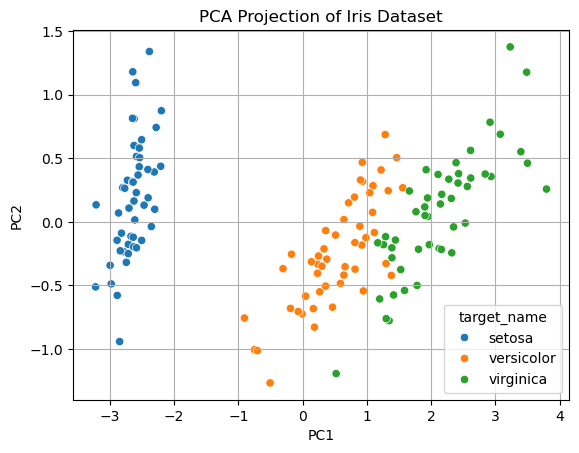

In [174]:
def plot_pca_scatter(X, y, iris):
    """
    Perform PCA on the dataset and plot the first two principal components.
    """
    X_pca = PCA(n_components=2).fit_transform(X)
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['target_name'] = [iris.target_names[i] for i in y]
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target_name')
    plt.title('PCA Projection of Iris Dataset')
    plt.grid(True)
    plt.show()

# Call the function
plot_pca_scatter(X, y, iris)


## Validation Curve: Hidden Layer Size vs Accuracy

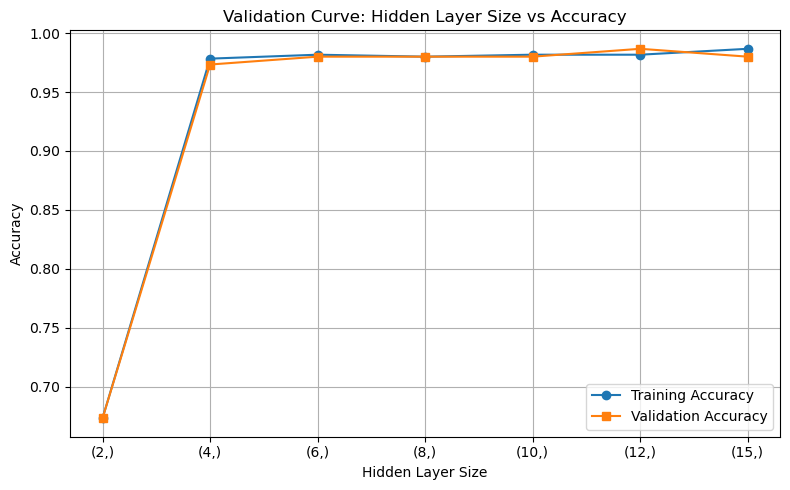

In [176]:
def plot_validation_curve_hidden_layers(X, y):
    """
    Plot training and validation accuracy for different hidden layer sizes using a validation curve.
    """
    layer_sizes = [(2,), (4,), (6,), (8,), (10,), (12,), (15,)]
    train_scores, test_scores = validation_curve(
        MLPClassifier(activation='logistic', solver='adam', max_iter=2000, random_state=42),
        X, y,
        param_name='hidden_layer_sizes',
        param_range=layer_sizes,
        cv=5,
        scoring='accuracy')
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    
    plt.figure(figsize=(8, 5))
    plt.plot([str(s) for s in layer_sizes], train_mean, label='Training Accuracy', marker='o')
    plt.plot([str(s) for s in layer_sizes], test_mean, label='Validation Accuracy', marker='s')
    plt.title('Validation Curve: Hidden Layer Size vs Accuracy')
    plt.xlabel('Hidden Layer Size')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function
plot_validation_curve_hidden_layers(X, y)

## Overfitting vs Underfitting

In [178]:
def compare_underfitting_overfitting(X_train, X_test, y_train, y_test):
    """
    Train a very small (underfitting) and a very large (overfitting) MLP model,
    then print their accuracy scores on the test set.
    """
    # Underfitting: very small model
    under_model = MLPClassifier(hidden_layer_sizes=(2,), activation='relu', max_iter=2000, random_state=42)
    under_model.fit(X_train, y_train)
    under_acc = accuracy_score(y_test, under_model.predict(X_test))

    # Overfitting: very large model
    over_model = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', max_iter=2000, random_state=42)
    over_model.fit(X_train, y_train)
    over_acc = accuracy_score(y_test, over_model.predict(X_test))

    print(f'Underfitting Model Accuracy: {under_acc:.2f}')
    print(f'Overfitting Model Accuracy: {over_acc:.2f}')

# Call the function
compare_underfitting_overfitting(X_train, X_test, y_train, y_test)

Underfitting Model Accuracy: 0.93
Overfitting Model Accuracy: 1.00


## Junk Feature Stress Test

In [180]:
def evaluate_with_junk_features(X, y):
    """
    Add random noise features to the dataset and evaluate model accuracy.
    """
    X_junk = np.hstack((X, np.random.rand(X.shape[0], 5)))
    clf_junk = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=2000, random_state=42)
    score_junk = cross_val_score(clf_junk, X_junk, y, cv=5).mean()
    print(f'Model Accuracy with Junk Features: {score_junk:.2f}')

# Call the function
evaluate_with_junk_features(X, y)

Model Accuracy with Junk Features: 0.99



 Activation Function: relu
 Accuracy: 96.67%
 Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



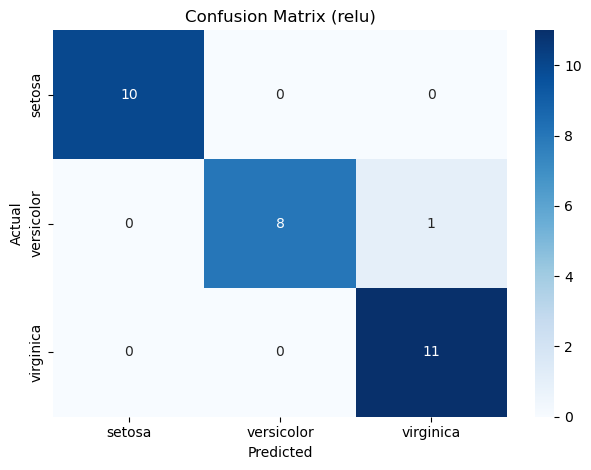


 Activation Function: tanh
 Accuracy: 96.67%
 Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.89      0.94         9
   virginica       0.92      1.00      0.96        11

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



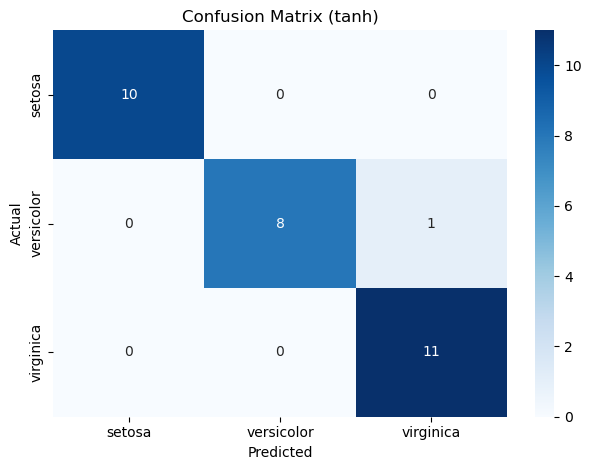


 Activation Function: logistic
 Accuracy: 100.00%
 Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



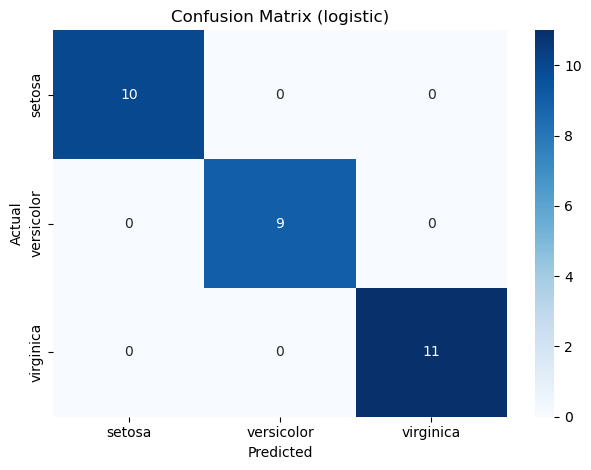

In [181]:
# Function to compare activation functions
def train_evaluate_mlp(X_train, X_test, y_train, y_test, target_names):
    for act in ['relu', 'tanh', 'logistic']:
        clf = MLPClassifier(hidden_layer_sizes=(10, 5), activation=act, max_iter=2000, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f'\n Activation Function: {act}')
        print(f' Accuracy: {acc * 100:.2f}%')
        print(' Classification Report:\n', classification_report(y_test, y_pred, target_names=target_names))
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(f'Confusion Matrix ({act})')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

# Run the comparison
train_evaluate_mlp(X_train, X_test, y_train, y_test, target_names)

## Best Model Evaluation

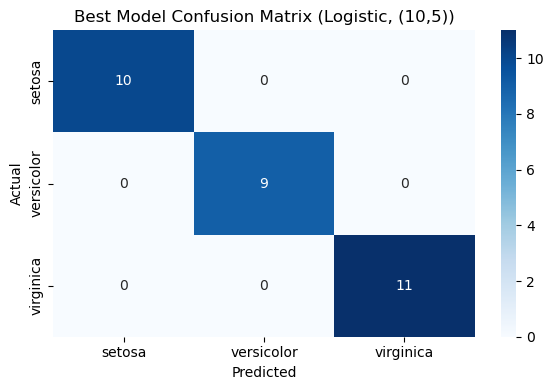

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [183]:
def train_and_evaluate_best_model(X_train, y_train, X_test, y_test, target_names):
    """
    Train the best MLP model configuration and evaluate it using confusion matrix and classification report.
    """
    # Train the best model
    best_model = MLPClassifier(hidden_layer_sizes=(10, 5), activation='logistic', solver='adam', max_iter=2000, random_state=42)
    best_model.fit(X_train, y_train)
    y_pred_best = best_model.predict(X_test)

    # Evaluate
    conf_matrix = confusion_matrix(y_test, y_pred_best)
    report = classification_report(y_test, y_pred_best, target_names=target_names)

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=target_names, yticklabels=target_names)
    plt.title("Best Model Confusion Matrix (Logistic, (10,5))")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Print full report
    print(report)

# Call the function
train_and_evaluate_best_model(X_train, y_train, X_test, y_test, target_names)

## Loss Curve

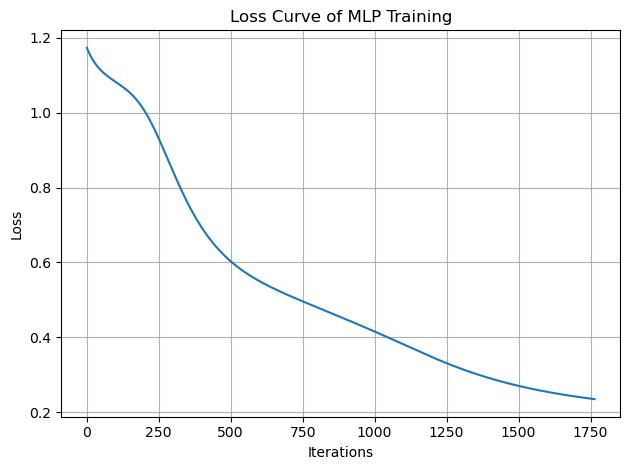

In [185]:
def plot_loss_curve(best_model):
    """
    Plot the loss curve of the trained MLP model.
    """
    plt.plot(best_model.loss_curve_)
    plt.title('Loss Curve of MLP Training')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_loss_curve(best_model)

## Learning Curve

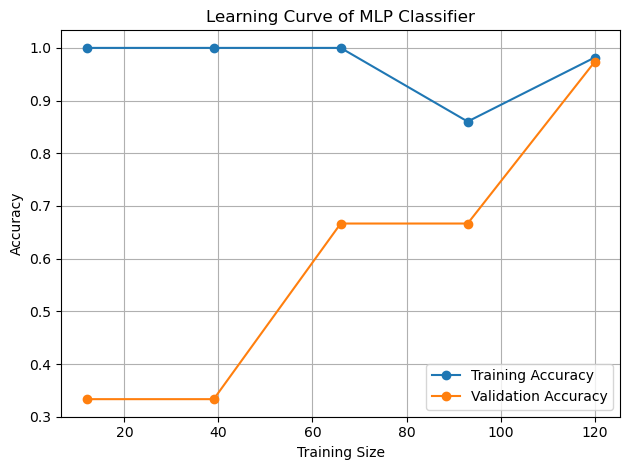

In [225]:
def plot_learning_curve(best_model, X, y):
    """
    Plot the learning curve for the given MLP model using training and validation accuracy.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring='accuracy')
    
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation Accuracy')
    plt.title('Learning Curve of MLP Classifier')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_learning_curve(best_model, X, y)

## Noise Robustness Testing

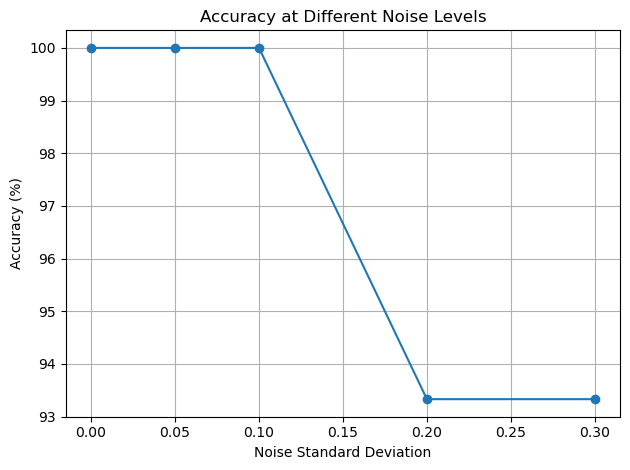

In [219]:
def test_noise_robustness(X, y, best_model):
    """
    Evaluate model accuracy at different levels of Gaussian noise added to features.
    """
    noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]
    accuracy_with_noise = []

    for noise in noise_levels:
        X_noisy = X + np.random.normal(0, noise, X.shape)
        X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_noisy, y, test_size=0.2, random_state=42)
        best_model.fit(X_train_n, y_train_n)
        acc = accuracy_score(y_test_n, best_model.predict(X_test_n))
        accuracy_with_noise.append(round(acc * 100, 2))

    plt.plot(noise_levels, accuracy_with_noise, marker='o')
    plt.title('Accuracy at Different Noise Levels')
    plt.xlabel('Noise Standard Deviation')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
test_noise_robustness(X, y, best_model)